In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install razdel
!pip install navec
!pip install slovnet
!pip install ipymarkup
!pip install pymorphy2
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
!wget https://storage.yandexcloud.net/natasha-slovnet/packs/slovnet_syntax_news_v1.tar
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar

!wget https://github.com/dkulagin/kartaslov/raw/master/dataset/kartaslovsent/kartaslovsent.csv

!pip3 install colorama

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from razdel import tokenize, sentenize
from navec import Navec
from slovnet.model.emb import NavecEmbedding
from slovnet import Syntax

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score

import pymorphy2

from scipy.spatial.distance import cosine
from sklearn.neighbors import  NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier as KNN

from collections import defaultdict
import re

from json import dumps, load

from colorama import Back


np.random.seed(42)

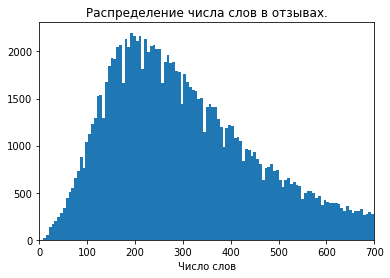

In [ ]:
data = pd.read_csv(PATH)
def count_words(row):
    return len(row.split())

r = data['text'].apply(count_words)
plt.hist(r, bins=350)
plt.title('Распределение числа слов в отзывах.')
plt.xlabel('Число слов')
plt.xlim((0, 700))  # лимит на 700 словах, но максимум слов порядка 1000
plt.show()

In [ ]:
path = '/content/navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [ ]:
class TextDataset(Dataset):    
    def __init__(self):
        self.targets = {"neg": 0, "neu": 1, "pos": 2}
        self.max_len = 700
        self.data = pd.read_csv(PATH).iloc[:70000]
        #self.data = self.data.filter(lambda x: len(x['text'].split()) > 50)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample, target = self.data.iloc[idx]
        sample = [_.text for _ in tokenize(sample)]
        if len(sample) > self.max_len:
          sample = sample[:self.max_len]
        sample = sample + ["<PAD>"]*(self.max_len-len(sample))
        sample = [navec.vocab.get(x, navec.vocab.unk_id) for x in sample]
        target = self.targets[target]
        return torch.LongTensor(sample), torch.LongTensor([target])

In [ ]:
batch_size = 200
dataset = TextDataset()
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
train_iterator = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_iterator = DataLoader(test_set, batch_size=batch_size)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers, dropout, bidirectional=False):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = NavecEmbedding(navec)
        self.bi = bidirectional
        self.rnn = nn.GRU(embedding_dim, hidden_dim, dropout = dropout, num_layers=self.num_layers, bidirectional=self.bi)
        self.fc = nn.Linear(hidden_dim*self.num_layers, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(1)

    def init_hidden(self, batch_size):
        mult = 2 if self.bi else 1
        return torch.zeros(mult * self.num_layers, batch_size, self.hidden_dim).to(device)
        
    def forward(self, x):
        #text,shape = [sent len, batch size]
        
        embedded = self.embedding(x)  # Делаем эмбеддинг
        #embedded.shape = [sent len, batch size, emb dim]
        #print(embedded.shape)
        output, self.hidden =  self.rnn.forward(embedded, self.hidden)   # Прогоняем через Rnn
        #hidden.shape = [1, batch size, hid dim]
        #print(self.hidden)
        x = self.fc(torch.cat((self.hidden[-2,:,:], self.hidden[-1,:,:]), dim = 1))
        x = self.dropout(x)
        return x.squeeze(0)

In [ ]:
import torch.optim as optim

INP_DIM = 700
EMB_DIM = 300
HID_DIM = 512
NUM_LAYERS = 2
DROPOUT = 0.75
OUT_DIM = 3
N_EPOCH = 15
BIDIRECTIONAL = True


model = RNN(INP_DIM, EMB_DIM, HID_DIM, OUT_DIM, NUM_LAYERS, DROPOUT, BIDIRECTIONAL).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.7/dist-packages/slovnet/model/emb.py:46: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  torch.from_numpy(navec.pq.indexes),


In [ ]:
losses_train = []
losses_test = []

for i in range(N_EPOCH):
  model.train()
  avg_loss = 0
  for j, (x, y) in tqdm(enumerate(train_iterator, 1), total=len(train_iterator), position=0, leave=True):
    y = y.squeeze(1).to(device)
    x = x.permute(1, 0).to(device)
    optimizer.zero_grad()
    model.hidden = model.init_hidden(x.size(1)) 
    output = model.forward(x)
    loss_train = criterion(output, y)
    loss_train.backward()
    avg_loss += loss_train.item()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
    optimizer.step()
  losses_train.append(avg_loss / j)
  avg_loss = 0
  model.eval()
  test_acc = []
  for j, (x, y) in tqdm(enumerate(test_iterator, 1), total=len(test_iterator), position=0, leave=True):
    y = y.squeeze(1).to(device)
    x = x.permute(1, 0).to(device)
    model.hidden = model.init_hidden(x.size(1)) 
    output = model.forward(x)
    test_acc.append(accuracy_score(torch.argmax(output, axis=1).cpu(), y.cpu()))
    loss_test = criterion(output, y)
    avg_loss += loss_test.item()
  losses_test.append(avg_loss / j)

  print("\nepoch", i)
  print("train_loss", losses_train[-1])
  print("test_loss", losses_test[-1], ", test accuracy", np.array(test_acc).mean())
  print()

  0%|          | 0/280 [00:00<?, ?it/s]


epoch 0
train_loss 0.8597637319139072
test_loss 0.6090377994946071 , test accuracy 0.8067857142857144



  0%|          | 0/280 [00:00<?, ?it/s]


epoch 1
train_loss 0.8477341773254531
test_loss 0.5552148529461451 , test accuracy 0.8022142857142859



  0%|          | 0/280 [00:00<?, ?it/s]


epoch 2
train_loss 0.8414186296718461
test_loss 0.5551061621734075 , test accuracy 0.8027142857142857



  0%|          | 0/280 [00:00<?, ?it/s]


epoch 3
train_loss 0.8330604527677808
test_loss 0.5697154326098306 , test accuracy 0.7899285714285713



 31%|███▏      | 22/70 [00:29<01:03,  1.32s/it]

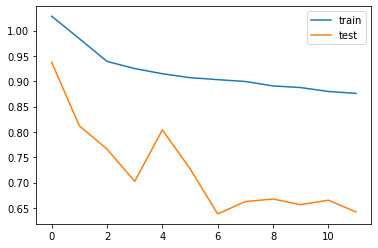

In [ ]:
plt.plot(losses_train, label="train")
plt.plot(losses_test, label ="test")
plt.legend()

In [ ]:
results = []
model.eval()
for x, y in train_iterator:
    y = y.squeeze(1).to(device)
    x = x.permute(1, 0).to(device)
    model.hidden = model.init_hidden(x.size(1)) 
    output = model.forward(x)
    results.append(accuracy_score(torch.argmax(output, axis = 1).cpu(), y.cpu()))

print(np.array(results).mean())


0.831375


In [ ]:
results = []
model.eval()
for x, y in test_iterator:
    y = y.squeeze(1).to(device)
    x = x.permute(1, 0).to(device)
    model.hidden = model.init_hidden(x.size(1)) 
    output = model.forward(x)
    results.append(accuracy_score(torch.argmax(output, axis = 1).cpu(), y.cpu()))

print(np.array(results).mean())

0.803642857142857


In [ ]:
bi = "" if BIDIRECTIONAL else "non "
#torch.save(model.state_dict(), f"{PATH_SAVE}navec_{EMB_DIM}_h_{HID_DIM}_GRU({bi}bi)_drop_{DROPOUT}_{N_EPOCH}_epochs.pth")

In [ ]:
bi = "" if BIDIRECTIONAL else "non "
model.load_state_dict(torch.load(f"{PATH_SAVE}navec_{EMB_DIM}_h_{HID_DIM}_GRU({bi}bi)_drop_{DROPOUT}_{N_EPOCH}_epochs.pth"))
model.eval()

RNN(
  (embedding): NavecEmbedding(id='hudlit_v1_12B_500K_300d_100q', indexes=[...], codes=[...])
  (rnn): GRU(300, 512, num_layers=2, dropout=0.75, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=3, bias=True)
  (dropout): Dropout(p=0.75, inplace=False)
  (softmax): Softmax(dim=1)
)

## Анализ атрибутивной тональности и визуализация

## kNN только по эталонным словам (словам из словаря тональности)

Возьмем проекцию на 2 измерения с помощью PCA

In [ ]:
emb = torch.Tensor([navec[vec] for vec in navec.vocab.words])
words = navec.vocab.words

In [ ]:
n_dim = 2
u, s, vh = torch.pca_lowrank(emb)
s[n_dim::] = 0
emb_2d = torch.matmul(emb, vh[:, :n_dim])


In [ ]:
tonal_dict = pd.read_csv("/content/kartaslovsent.csv", sep=";")
tonal_dict.head()

,term,tag,value,pstv,ngtv,neut,dunno,pstvNgtvDisagreementRatio
0,абажур,NEUT,0.08,0.185,0.037,0.580,0.198,0.00
1,аббатство,NEUT,0.10,0.192,0.038,0.578,0.192,0.00
2,аббревиатура,NEUT,0.08,0.196,0.000,0.630,0.174,0.00
3,абзац,NEUT,0.00,0.137,0.000,0.706,0.157,0.00
4,абиссинец,NEUT,0.28,0.151,0.113,0.245,0.491,0.19


<BarContainer object of 3 artists>

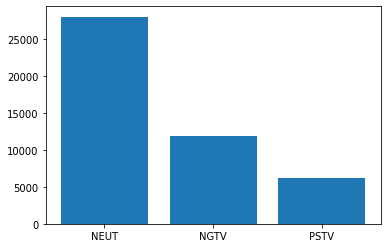

In [ ]:
plt.bar(tonal_dict.tag.unique(), tonal_dict.tag.value_counts())

In [ ]:
morph = pymorphy2.MorphAnalyzer()

cnt = 0
adjs = []
for w in tqdm(words):
  m = morph.parse(w)
  if m[0].tag.POS in ["ADJF", "ADJS"]:
    adjs.append(cnt)
  cnt+=1

In [ ]:
print(len(adjs))
words = np.array(words)
words_adjs = words[adjs]
emb2d_adjs = emb_2d[adjs, :]
emb_adjs = emb[adjs, :]
emb2d_words_adjs = {word: emb for word,emb in zip(words_adjs, emb2d_adjs)}
#words_emb2d_adjs = {emb: word for word,emb in zip(words_adjs, emb2d_adjs)}
emb_words_adjs = {word: emb for word,emb in zip(words_adjs, emb_adjs)}
#words_emb_adjs = {emb: word for word,emb in zip(words_adjs, emb_adjs)}


98840


In [ ]:
standard_words = [word for word in tonal_dict.term if word in emb_words_adjs]
print(f"Total standard words: {len(standard_words)}")

Total standard words: 6440


In [ ]:
import random
random.shuffle(standard_words)
# разделим на train и test
standard_words_train = standard_words[:int(0.8*len(standard_words))]
standard_words_test = standard_words[int(0.8*len(standard_words)):]

In [ ]:
classes = {"PSTV": 0, "NEUT": 1, "NGTV": 2}
dict_pairs_train = dict(tonal_dict[["term", "tag"]][tonal_dict.term.isin(standard_words_train)].itertuples(index=False))
X_train = np.array([emb_words_adjs[word].numpy() for word in dict_pairs_train])
y_train = np.array([classes[dict_pairs_train[word]] for word in dict_pairs_train])

dict_pairs_test = dict(tonal_dict[["term", "tag"]][tonal_dict.term.isin(standard_words_test)].itertuples(index=False))
X_test = np.array([emb_words_adjs[word].numpy() for word in dict_pairs_test])
y_test = np.array([classes[dict_pairs_test[word]] for word in dict_pairs_test])

5
10
20
25
30
35
40
50
55
60


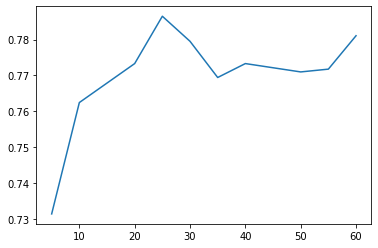

In [ ]:
from sklearn.metrics import f1_score

scores = []
_n_neighbors = [5, 10, 20, 25, 30, 35, 40, 50, 55, 60]
for n_neigh in _n_neighbors:
  print(n_neigh)
  estimator = KNN(n_neighbors=n_neigh, metric='euclidean', n_jobs=-1)
  estimator.fit(X_train, y_train)
  predicted = estimator.predict(X_test)
  scores.append(f1_score(predicted, y_test, average="micro"))

plt.plot(_n_neighbors, scores)

In [ ]:
estimator = KNN(n_neighbors=25, metric='euclidean', n_jobs=-1)
estimator.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=-1, n_neighbors=25, p=2,
                     weights='uniform')

In [ ]:
from sklearn.externals import joblib
joblib.dump(estimator, 'KNN.pkl')
estimator  = joblib.load('KNN.pkl' , mmap_mode ='r')

In [ ]:
# from sklearn.naive_bayes import GaussianNB
# estimator = GaussianNB()
# estimator.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
from sklearn.metrics import classification_report

predicted = estimator.predict(X_test)
print(classification_report(predicted, y_test, target_names=["PSTV", "NEUT", "NGTV"]))

              precision    recall  f1-score   support

        PSTV       0.51      0.83      0.64       139
        NEUT       0.90      0.81      0.85       889
        NGTV       0.68      0.70      0.69       260

    accuracy                           0.79      1288
   macro avg       0.70      0.78      0.72      1288
weighted avg       0.81      0.79      0.79      1288



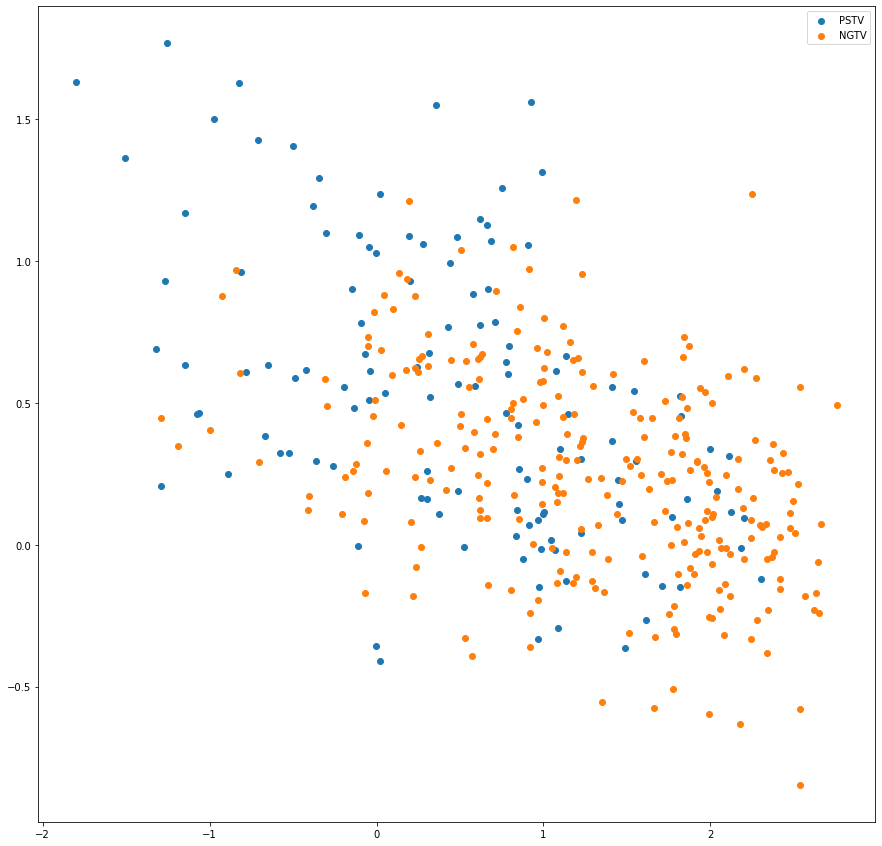

In [ ]:
coords_2d = np.array([emb2d_words_adjs[word].numpy() for word in dict_pairs_test])

plt.figure(figsize=(15, 15))
plt.scatter(coords_2d[predicted == 0][:, 0], coords_2d[predicted == 0][:, 1], label="PSTV")
# plt.scatter(coords_2d[predicted == 0][:, 0], coords_2d[predicted == 0][:, 1], label="NEUT")
plt.scatter(coords_2d[predicted == 2][:, 0], coords_2d[predicted == 2][:, 1], label="NGTV")
plt.legend()
plt.show()

## Работа с настоящими отзывами

In [ ]:
navec_news = Navec.load('navec_news_v1_1B_250K_300d_100q.tar')
syntax = Syntax.load('slovnet_syntax_news_v1.tar')
syntax.navec(navec_news)

In [ ]:
chunk = []
r = data.iloc[np.random.choice(range(len(data)))]["text"]
rewiew = [_.text for _ in tokenize(r)]
for sent in sentenize(r):
  tokens = [_.text for _ in tokenize(sent.text)]
  chunk.append(tokens)

print(r)




for markup in syntax.map(chunk):
  for token in markup.tokens:
      w = token.text
      m = morph.parse(w)
      if m[0].tag.POS in ["ADJF", "ADJS"]:
        n_f = m[0].normal_form
        if n_f in emb_words_adjs:
          e = emb_words_adjs[n_f]
          pred_class  = estimator.predict(e.reshape(1, -1))[0]
          pred_word_token = markup.tokens[int(token.head_id)-1]
          m = morph.parse(pred_word_token.text)
          if not m[0].tag.POS in ["NOUN", "NPRO"] or m[0].normal_form in ['который', 'свой', 'тот', 'этот', 'весь', 'такой', 'такого', 'какой-то', 'самый']:
              continue
          # while True:
          #   m = morph.parse(pred_word_token.text)
          #   if m[0].tag.POS in ["NOUN", "NPRO"]:
          #     break
          #   if pred_word_token.head_id == '0' or pred_word_token.head_id == pred_id:
          #     break
          #   pred_id = pred_word_token.id
          #   pred_word_token = markup.tokens[int(pred_word_token.head_id)-1]

          template = pred_word_token.text
          if pred_class == 0:
            #print(f"{w}: proba_good-{proba_good}")
            print(f"{template} {Back.GREEN+w+Back.RESET}")
            pass
          elif pred_class == 2:
            #print(f"{w}: proba_bad-{proba_bad}")
            print(f"{template} {Back.RED+w+Back.RESET}")
            

  

Начав свою карьеру еще в конце 1980-х, лишь к середине следующего десятилетия, в 1995 году, режиссер Брайан Сингер приобретает огромную популярность за успех ленты «Подозрительные лица». Брайан показал себя очень талантливым кинематографистом, который, не имея больших финансовых средств, может нагнетать напряжение и в обыкновенной разговорной сцене, что под силу мне кажется, далеко не всем режиссерам. Та лента, помимо неплохого кассового успеха (все-таки бюджет у фильма вышел очень маленький) получила также и две премии Оскар: лучший сценарий и Лучшая мужская роль второго плана (Кевин Спейси). 
 
 После такого успеха, Сингер решил продолжить работу в этом жанре и следующей своей работой он выбирает экранизацию очередной повести одного из самых экранизируемых писателей мира – Стивена Кинга. Сама же лента получилась, на мой взгляд, несколько неровной и чуток отторгающей. Во многом благодаря самому сюжету, который вышел довольно грубоватым и очень уж давящим, особенно учитывая такой непри